In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timezone
import torch
from model_definitions import *

torch.manual_seed(42)

SPORTSBOOKS = ['PointsBet (US)', 'DraftKings']

In [2]:
# Load historical odds data and parse json
with open('../data/historical_odds.json', 'r') as f:
    data = json.load(f)
    
# Only keep games from the 2020-21 season onwards
data = [x for x in data if datetime.fromisoformat(x['timestamp']) > datetime(2020, 12, 20, tzinfo=timezone.utc)]

def contains_sportsbook(bookmakers):
    for bookmaker in bookmakers:
        if bookmaker['title'] in SPORTSBOOKS:
            return True
    return False

# Extract data for each event
odds_data = [x['data'] for x in data]
odds_data = [x for x in odds_data]
#Flatten the list of lists
odds_data = [item for sublist in odds_data for item in sublist]
odds_data = [x for x in odds_data if contains_sportsbook(x['bookmakers'])]
odds_data = {x['id']: x for x in odds_data}
odds_data = list(odds_data.values())

# Only keep games with odds from allowed sportsbooks
for i in range(len(odds_data)):
    odds_data[i]['bookmakers'] = [x for x in odds_data[i]['bookmakers'] if x['title'] in SPORTSBOOKS]
    
# Convert game data to pandas dataframe
odds_data = pd.json_normalize(odds_data)
odds_data.drop(columns=['sport_key', 'sport_title', 'id'], inplace=True)
odds_data['commence_time'] = pd.to_datetime(odds_data['commence_time'])
# Convert commence_time to eastern time
odds_data['commence_time'] = odds_data['commence_time'].dt.tz_convert('US/Eastern')
print(odds_data.head())

              commence_time           home_team              away_team  \
0 2020-12-25 12:10:00-05:00          Miami Heat   New Orleans Pelicans   
1 2020-12-25 14:40:00-05:00     Milwaukee Bucks  Golden State Warriors   
2 2020-12-25 17:10:00-05:00      Boston Celtics          Brooklyn Nets   
3 2020-12-25 20:10:00-05:00  Los Angeles Lakers       Dallas Mavericks   
4 2020-12-25 22:40:00-05:00      Denver Nuggets   Los Angeles Clippers   

                                          bookmakers  
0  [{'key': 'pointsbetus', 'title': 'PointsBet (U...  
1  [{'key': 'pointsbetus', 'title': 'PointsBet (U...  
2  [{'key': 'pointsbetus', 'title': 'PointsBet (U...  
3  [{'key': 'pointsbetus', 'title': 'PointsBet (U...  
4  [{'key': 'pointsbetus', 'title': 'PointsBet (U...  


In [3]:
# Find the game id asosiated with each game
games = pd.read_csv('../data/games.csv')
games['GAME_DATE'] = pd.to_datetime(games['GAME_DATE'])
games['GAME_DATE'] = games['GAME_DATE'].dt.date
games['GAME_ID'] = games['GAME_ID'].astype(str)
odds_data['GAME_DATE'] = odds_data['commence_time'].dt.date
odds_data['GAME_ID'] = np.nan

# Find the game id for each game
for i in range(len(odds_data)):
    game = odds_data.iloc[i]
    game_id = games[(games['GAME_DATE'] == game['GAME_DATE']) & (games['TEAM_NAME'] == game['home_team'])]['GAME_ID']
    if len(game_id) > 0:
        odds_data.at[i, 'GAME_ID'] = game_id.values[0]
    else:
        game_id = games[(games['GAME_DATE'] == game['GAME_DATE']) & (games['TEAM_NAME'] == game['away_team'])]['GAME_ID']
        if len(game_id) > 0:
            odds_data.at[i, 'GAME_ID'] = game_id.values[0]

# Drop games with no game id
odds_data.dropna(subset=['GAME_ID'], inplace=True)
odds_data['GAME_ID'] = odds_data['GAME_ID'].astype(int)
print(len(odds_data))
        
# Get maximum odds for each outcome for each game
odds_data['best_home_odds'] = np.nan
odds_data['best_away_odds'] = np.nan
odds_data['best_home_bookmaker'] = np.nan
odds_data['best_away_bookmaker'] = np.nan

for i in range(len(odds_data)):
    game = odds_data.iloc[i]
    home_team = game['home_team']
    away_team = game['away_team']
    home_odds = [(bookmaker['title'], bookmaker['markets'][0]['outcomes'][i]['price']) for bookmaker in game['bookmakers'] for i in range(2) if bookmaker['markets'][0]['outcomes'][i]['name'] == home_team]
    away_odds = [(bookmaker['title'], bookmaker['markets'][0]['outcomes'][i]['price']) for bookmaker in game['bookmakers'] for i in range(2) if bookmaker['markets'][0]['outcomes'][i]['name'] == away_team]
    home_odds.sort(key=lambda x: x[1], reverse=True)
    away_odds.sort(key=lambda x: x[1], reverse=True)
    odds_data.at[i, 'best_home_odds'] = home_odds[0][1]
    odds_data.at[i, 'best_away_odds'] = away_odds[0][1]
    odds_data.at[i, 'best_home_bookmaker'] = home_odds[0][0]
    odds_data.at[i, 'best_away_bookmaker'] = away_odds[0][0]

odds_data.to_csv('../data/odds.csv', index=False)

/tmp/ipykernel_5386/4023921696.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '22000005' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  odds_data.at[i, 'GAME_ID'] = game_id.values[0]


4127


/tmp/ipykernel_5386/4023921696.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'PointsBet (US)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  odds_data.at[i, 'best_home_bookmaker'] = home_odds[0][0]
/tmp/ipykernel_5386/4023921696.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'DraftKings' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  odds_data.at[i, 'best_away_bookmaker'] = away_odds[0][0]


In [4]:
from torch.utils.data import Dataset, DataLoader

class GamesDataset(Dataset):
    def __init__(self, game_data, player_data, odds_data):
        self.games = game_data
        self.players = player_data
        # self.players = self.players.groupby(['GAME_ID', 'TEAM_ID']).filter(lambda x: len(x) >= 10)
        self.odds = odds_data
        self.game_ids = self.games['GAME_ID'].unique()
        
    def __len__(self):
        return len(self.game_ids.tolist())

    def __getitem__(self, idx):
        game_id = self.game_ids[idx]
        game = self.games[self.games['GAME_ID'] == game_id]
        home_team = game[game['HOME_TEAM'] == 1]
        away_team = game[game['HOME_TEAM'] == 0]
        home_team_players = self.players[(self.players['GAME_ID'] == game_id) & (self.players['TEAM_ID'] == home_team['TEAM_ID'].values[0])]
        away_team_players = self.players[(self.players['GAME_ID'] == game_id) & (self.players['TEAM_ID'] == away_team['TEAM_ID'].values[0])]
        # Sort players by seconds played
        home_team_players = home_team_players.sort_values(by='SEC', ascending=False)
        away_team_players = away_team_players.sort_values(by='SEC', ascending=False)
        home_team_players = home_team_players.iloc[:10]
        away_team_players = away_team_players.iloc[:10]
        # Drop columns that are not needed
        home_team_players.drop(columns=['GAME_ID', 'TEAM_ID', 'PLAYER_ID', 'GAME_DATE', 'SEASON'], inplace=True)
        away_team_players.drop(columns=['GAME_ID', 'TEAM_ID', 'PLAYER_ID', 'GAME_DATE', 'SEASON'], inplace=True)
        # Convert to numpy array
        home_team_players = home_team_players.to_numpy()
        away_team_players = away_team_players.to_numpy()
        input = np.array([home_team_players, away_team_players])
        # Convert to tensor
        input = torch.from_numpy(input).float()
        # Get outcome
        label = game['HOME_TEAM_WON'].values[0]
        # Get odds
        odds = self.odds[self.odds['GAME_ID'] == game['GAME_ID'].values[0]]
        home_odds = odds['best_home_odds'].values[0]
        away_odds = odds['best_away_odds'].values[0]
        return input, label, home_odds, away_odds

In [5]:
# Define betting rules to test
def uniform_betting(initial_bankroll, bankroll_fraction=0.1, threshold=0):
    def rule(bankroll, odds, win_probability):
        if abs(win_probability - .5) < threshold:
            return 0
        return initial_bankroll * bankroll_fraction
    return rule

def kelly_criterion(kelly_fraction=0.1, threshold=0):
    def rule(bankroll, odds, win_probability): 
        if abs(win_probability - .5) < threshold:
            return 0
        return bankroll * kelly_fraction * (win_probability * odds - (1 - win_probability)) / odds
    return rule

In [6]:

player_data = pd.read_csv('../data/rolling_averages.csv')
game_data = pd.read_csv('../data/games.csv')
odds_data = pd.read_csv('../data/odds.csv')

for season in ['2020-2021', '2021-2022', '2022-2023']:
    # Drop games that does not have data for both teams
    player_data = player_data.groupby('GAME_ID').filter(lambda x: len(x['TEAM_ID'].unique()) == 2)

    # only keep games in the 2022-23 regular season
    game_data['GAME_DATE'] = pd.to_datetime(game_data['GAME_DATE'])
    game_data = game_data[(game_data['SEASON_ID'] >= 22020) & (game_data['SEASON_ID'] < 22023)]
    game_data.sort_values(by='GAME_DATE', inplace=True)

    # only keep games with odds
    game_data = game_data[game_data['GAME_ID'].isin(odds_data['GAME_ID'])]

    # only keep games with rolling averages
    game_data = game_data[game_data['GAME_ID'].isin(player_data['GAME_ID'])]

    dataset = GamesDataset(game_data, player_data, odds_data)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    bankroll = 1000
    # Define bettring rules to test
    hundreth_uniform = uniform_betting(bankroll, bankroll_fraction=0.01)
    tenths_uniform = uniform_betting(bankroll, bankroll_fraction=0.1)
    tenths_kelly = kelly_criterion(kelly_fraction=0.1)
    eighth_kelly = kelly_criterion(kelly_fraction=0.125)
    sixth_kelly = kelly_criterion(kelly_fraction=0.166)
    tenths_uniform_threshold_1 = uniform_betting(bankroll, bankroll_fraction=0.1, threshold=0.1)
    tenths_uniform_threshold_2 = uniform_betting(bankroll, bankroll_fraction=0.1, threshold=0.2)
    tenths_uniform_threshold_3 = uniform_betting(bankroll, bankroll_fraction=0.1, threshold=0.3)
    eighth_kelly_threshold_1 = kelly_criterion(kelly_fraction=0.125, threshold=0.1)
    eighth_kelly_threshold_2 = kelly_criterion(kelly_fraction=0.125, threshold=0.2)
    eighth_kelly_threshold_3 = kelly_criterion(kelly_fraction=0.125, threshold=0.3)

    betting_rules = []
    betting_rules.append(hundreth_uniform)
    betting_rules.append(tenths_uniform)
    betting_rules.append(tenths_kelly)
    betting_rules.append(eighth_kelly)
    betting_rules.append(sixth_kelly)
    betting_rules.append(tenths_uniform_threshold_1)
    betting_rules.append(tenths_uniform_threshold_2)
    betting_rules.append(tenths_uniform_threshold_3)
    betting_rules.append(eighth_kelly_threshold_1)
    betting_rules.append(eighth_kelly_threshold_2)
    betting_rules.append(eighth_kelly_threshold_3)

    bankroll_history = np.zeros((len(dataset) + 1, len(betting_rules)))
    # Set the first row to the initial bankroll
    bankroll_history[0, :] = bankroll

    odds_history = np.zeros(len(dataset))
    bet_history = np.zeros((len(dataset), len(betting_rules)))
    win_history = np.zeros(len(dataset))


    num_players = dataset[0][0].shape[1]
    num_features = dataset[0][0].shape[2]

    # Load model
    model = NeuralNetwork(num_players=num_players, num_features=num_features, hidden_layers=[92, 210])
    model.load_state_dict(torch.load('../models/modelv1.pth'))
    model.eval()

    model_predictions = []
    bookmaker_predictions = []
    labels = []
    bets_placed = 0
    bets_won = 0
    for i, (input, label, home_odds, away_odds) in enumerate(dataloader):
        output = model(input)
        output = output.item()
        model_predictions.append(output)
        label = label.item()
        home_odds = home_odds.item()
        away_odds = away_odds.item()
        labels.append(label)
        if 1/home_odds > .5:
            bookmaker_predictions.append(1)
        else:
            bookmaker_predictions.append(0)
        home_prediction = output
        away_prediction = 1 - output
        # choose the highest positive ev bet
        if home_prediction > 1/home_odds:
            for j, item in enumerate(betting_rules.items()):
                _, rule = item
                current_bankroll = bankroll_history[bets_placed, j]
                bet = rule(current_bankroll, home_odds, home_prediction)
                odds_history[bets_placed] = home_odds
                bet_history[bets_placed, j] = bet
                new_bankroll = current_bankroll - bet
                if label == 1:
                    new_bankroll += bet * home_odds
                bankroll_history[bets_placed+1, j] = new_bankroll
            if label == 1:
                bets_won += 1
                win_history[bets_placed] = 1
            else:
                win_history[bets_placed] = 0
            bets_placed += 1
        elif away_prediction > 1/away_odds:
            for j, item in enumerate(betting_rules.items()):
                _, rule = item
                current_bankroll = bankroll_history[bets_placed, j]
                bet = rule(current_bankroll, away_odds, away_prediction)
                odds_history[bets_placed] = away_odds
                bet_history[bets_placed, j] = bet
                new_bankroll = current_bankroll - bet
                if label == 0:
                    new_bankroll += bet * away_odds
                bankroll_history[bets_placed+1, j] = new_bankroll 
            if label == 0:
                bets_won += 1
                win_history[bets_placed] = 1
            else:
                win_history[bets_placed] = 0
            bets_placed += 1

RuntimeError: Error(s) in loading state_dict for NeuralNetwork:
	size mismatch for player_data_aggregator.conv1.weight: copying a param with shape torch.Size([2, 2, 10, 1]) from checkpoint, the shape in current model is torch.Size([2, 2, 2, 1]).

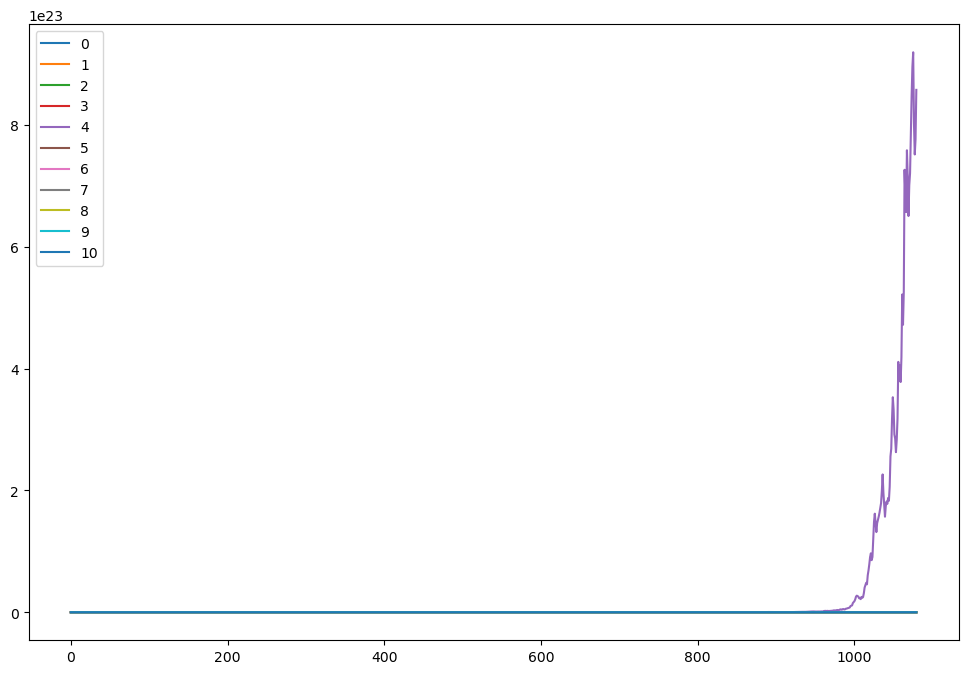

In [ ]:
def plot_bankroll_histories(bankroll_history, bets_placed, betting_rules):
    # Trim unused rows from bankroll history
    trimmed_bankroll_history = bankroll_history[:bets_placed+1, :]

    # Set up the plot
    plt.figure(figsize=(12, 8))

    # Plot each bankroll history
    for i, title, _ in enumerate(betting_rules.items()):
        plt.plot(trimmed_bankroll_history[:, i], label=title)

    # Add a legend and show the plot
    plt.legend()
    plt.show()

plot_bankroll_histories(bankroll_history, bets_placed, betting_rules)

In [ ]:
def plot_bankroll_histories(bankroll_history, bets_placed, betting_rules):
    # Trim unused rows from bankroll history
    trimmed_bankroll_history = bankroll_history[:bets_placed+1, :]

    # Set up the plot
    plt.figure(figsize=(12, 8))

    # Plot each bankroll history
    for i, _ in enumerate(betting_rules):
        plt.plot(trimmed_bankroll_history[:, i], label=str(i))

    # Add a legend and show the plot
    plt.legend()
    plt.show()

plot_bankroll_histories(bankroll_history, bets_placed, betting_rules)

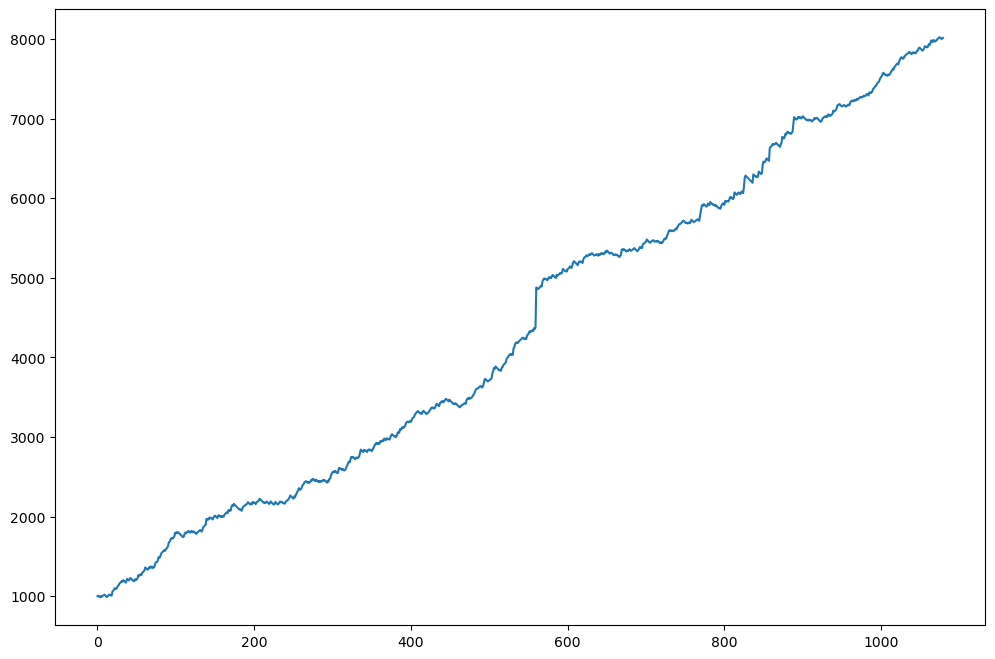

In [ ]:
# plot bankroll history for a single betting rule
plt.figure(figsize=(12, 8))
plt.plot(bankroll_history[:, 0])

In [ ]:
model_accuracy = np.sum(np.round(np.array(model_predictions)) == np.array(labels)) / len(labels)
bookmaker_accuracy = np.sum(np.array(bookmaker_predictions) == np.array(labels)) / len(labels)
pct_bets_placed = bets_placed / len(labels)
pct_bets_won = bets_won / bets_placed
best_performing_rule = np.argmax(bankroll_history[-1, :])
print('Model accuracy: ', model_accuracy)
print('Bookmaker accuracy: ', bookmaker_accuracy)
print('PCT bets placed: ', pct_bets_placed)
print('PCT bets won: ', pct_bets_won)
print('Best performing rule: ', best_performing_rule, ' with bankroll: ', bankroll_history[-1, best_performing_rule])

Model accuracy:  0.6466492602262838
Bookmaker accuracy:  0.5456919060052219
PCT bets placed:  0.939077458659704
PCT bets won:  0.5940685820203893
Best performing rule:  4  with bankroll:  8.574937353774844e+23
